## Import Libraries

In [1]:
import pmdarima

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_pacf

## Import Data

In [68]:
df_AAPL = pd.read_csv('AAPL_hist_price.csv')
df_FB = pd.read_csv('FB_hist_price.csv')
df_ADBE = pd.read_csv('ADBE_hist_price.csv')
df_AMD = pd.read_csv('AMD_hist_price.csv')
df_BABA = pd.read_csv('BABA_hist_price.csv')
df_INTC = pd.read_csv('INTC_hist_price.csv')
df_MSFT = pd.read_csv('MSFT_hist_price.csv')
df_PYPL = pd.read_csv('PYPL_hist_price.csv')
df_QCOM = pd.read_csv('QCOM_hist_price.csv')
df_SHOP = pd.read_csv('SHOP_hist_price.csv')

In [69]:
# Stocks we will build models for 
symbols= ["AAPL", "FB", "ADBE", "INTC", "PYPL", "BABA", "QCOM", "SHOP", "AMD", "MSFT"]

# dataset
df = [df_AAPL, df_FB, df_ADBE, df_INTC, df_PYPL, df_BABA, df_QCOM, df_SHOP, df_AMD, df_MSFT]

## Modify Columns for plotting

In [70]:
#for idx in range(len(df)):
    #x = df[idx]
    
    # set label as DateTimeIndex
    #x['label'] = pd.DatetimeIndex(x.label)
    
    # set index for label
    #x = x.set_index('label')
    
    ## reverse index time - from furthest to nearest
    #x = x.iloc[::-1]

#for i,x in enumerate(df):
    #df[i]['label']  = pd.DatetimeIndex(df[i].label)
    #df[i] = df[i].set_index('label')
    #df[i] = df[i].iloc[::-1] 

In [71]:
# set label as DateTimeIndex
df_AAPL['label'] = pd.DatetimeIndex(df_AAPL.label)
df_FB['label'] = pd.DatetimeIndex(df_FB.label)
df_ADBE['label'] = pd.DatetimeIndex(df_ADBE.label)
df_AMD['label'] = pd.DatetimeIndex(df_AMD.label)
df_BABA['label'] = pd.DatetimeIndex(df_BABA.label)
df_INTC['label'] = pd.DatetimeIndex(df_INTC.label)
df_MSFT['label'] = pd.DatetimeIndex(df_MSFT.label)
df_PYPL['label'] = pd.DatetimeIndex(df_PYPL.label)
df_QCOM['label'] = pd.DatetimeIndex(df_QCOM.label)
df_SHOP['label'] = pd.DatetimeIndex(df_SHOP.label)

# set index for label
df_AAPL = df_AAPL.set_index('label')
df_FB = df_FB.set_index('label')
df_ADBE = df_ADBE.set_index('label')
df_AMD = df_AMD.set_index('label')
df_BABA = df_BABA.set_index('label')
df_INTC = df_INTC.set_index('label')
df_MSFT = df_MSFT.set_index('label')
df_PYPL = df_PYPL.set_index('label')
df_QCOM = df_QCOM.set_index('label')
df_SHOP = df_SHOP.set_index('label')

## reverse index time - from furthest to nearest
df_AAPL = df_AAPL.iloc[::-1]
df_FB = df_FB.iloc[::-1]
df_ADBE = df_ADBE.iloc[::-1]
df_AMD = df_AMD.iloc[::-1]
df_BABA = df_BABA.iloc[::-1]
df_INTC = df_INTC.iloc[::-1]
df_MSFT = df_MSFT.iloc[::-1]
df_PYPL = df_PYPL.iloc[::-1]
df_QCOM = df_QCOM.iloc[::-1]
df_SHOP = df_SHOP.iloc[::-1]

## example dataset
df_AAPL.head()

,change,changeOverTime,changePercent,close,fClose,fHigh,fLow,fOpen,fVolume,high,...,open,subkey,symbol,uClose,uHigh,uLow,uOpen,uVolume,updated,volume
label,,,,,,,,,,,,,,,,,,,,,
2016-04-04,0.3275,-0.774146,0.0119,27.7800,25.8384,26.0872,25.6408,25.6757,149424816,28.0475,...,27.6050,NaN,AAPL,111.12,112.19,110.270,110.42,37356204,2021-02-05 02:16:39,149424816
2016-04-05,-0.2875,-0.776809,-0.0104,27.4525,25.5338,25.7477,25.4431,25.4641,106314608,27.6825,...,27.3775,NaN,AAPL,109.81,110.73,109.420,109.51,26578652,2021-02-05 02:17:33,106314608
2016-04-06,0.6050,-0.774472,0.0223,27.7400,25.8012,25.8059,25.3920,25.6315,105616308,27.7450,...,27.5575,NaN,AAPL,110.96,110.98,109.200,110.23,26404077,2021-02-05 02:16:05,105616308
2016-04-07,-0.0300,-0.779390,-0.0011,27.1350,25.2385,25.6757,25.1411,25.5664,127207480,27.6050,...,27.4875,NaN,AAPL,108.54,110.42,108.121,109.95,31801870,2021-02-05 02:16:05,127207480
2016-04-08,-0.0900,-0.779146,-0.0033,27.1650,25.2664,25.5245,25.1525,25.3245,94326960,27.4425,...,27.2275,NaN,AAPL,108.66,109.77,108.170,108.91,23581740,2021-02-05 02:17:01,94326960


In [72]:
df_AAPL = df_AAPL['fClose']
df_AAPL = pd.DataFrame(data=df_AAPL)

df_ADBE = df_ADBE['fClose']
df_ADBE = pd.DataFrame(data=df_ADBE)

df_AMD = df_AMD['fClose']
df_AMD = pd.DataFrame(data=df_AMD)

df_BABA = df_BABA['fClose']
df_BABA = pd.DataFrame(data=df_BABA)

df_FB = df_FB['fClose']
df_FB = pd.DataFrame(data=df_FB)

df_INTC = df_INTC['fClose']
df_INTC = pd.DataFrame(data=df_INTC)

df_MSFT = df_MSFT['fClose']
df_MSFT = pd.DataFrame(data=df_MSFT)

df_PYPL = df_PYPL['fClose']
df_PYPL = pd.DataFrame(data=df_PYPL)

df_QCOM = df_QCOM['fClose']
df_QCOM = pd.DataFrame(data=df_QCOM)

df_SHOP = df_SHOP['fClose']
df_SHOP = pd.DataFrame(data=df_SHOP)

In [73]:
## example dataset
df_AAPL.head()

,fClose
label,
2016-04-04,25.8384
2016-04-05,25.5338
2016-04-06,25.8012
2016-04-07,25.2385
2016-04-08,25.2664


## test stationarity - using ADF test

In [74]:
## function from Kaggle
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## AAPL

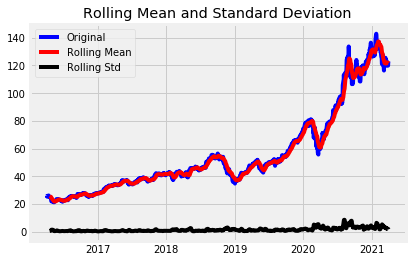

Results of dickey fuller test
Test Statistics                   0.270717
p-value                           0.975960
No. of lags used                 20.000000
Number of observations used    1237.000000
critical value (1%)              -3.435647
critical value (5%)              -2.863879
critical value (10%)             -2.568015
dtype: float64


In [75]:
test_stationarity(df_AAPL['fClose'])

## ADBE

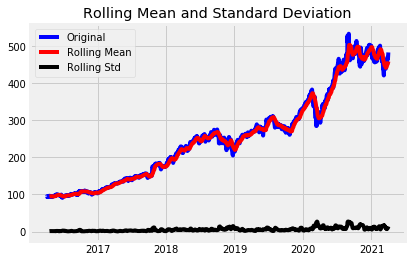

Results of dickey fuller test
Test Statistics                   0.085952
p-value                           0.965089
No. of lags used                 15.000000
Number of observations used    1243.000000
critical value (1%)              -3.435622
critical value (5%)              -2.863868
critical value (10%)             -2.568009
dtype: float64


In [76]:
test_stationarity(df_ADBE['fClose'])

## AMD

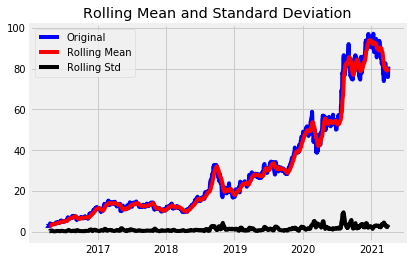

Results of dickey fuller test
Test Statistics                   0.012299
p-value                           0.959537
No. of lags used                 10.000000
Number of observations used    1248.000000
critical value (1%)              -3.435601
critical value (5%)              -2.863859
critical value (10%)             -2.568004
dtype: float64


In [77]:
test_stationarity(df_AMD['fClose'])

## BABA

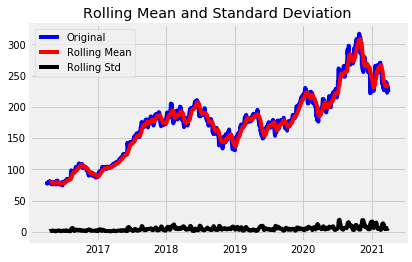

Results of dickey fuller test
Test Statistics                  -1.597665
p-value                           0.484766
No. of lags used                 22.000000
Number of observations used    1236.000000
critical value (1%)              -3.435652
critical value (5%)              -2.863881
critical value (10%)             -2.568016
dtype: float64


In [78]:
test_stationarity(df_BABA['fClose'])

## FB

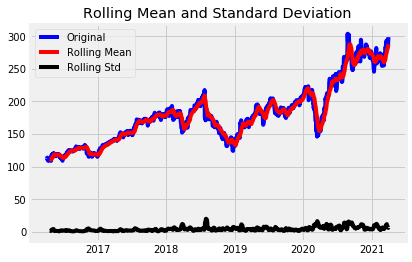

Results of dickey fuller test
Test Statistics                  -0.564912
p-value                           0.878715
No. of lags used                 18.000000
Number of observations used    1240.000000
critical value (1%)              -3.435635
critical value (5%)              -2.863874
critical value (10%)             -2.568012
dtype: float64


In [79]:
test_stationarity(df_FB['fClose'])

## INTC

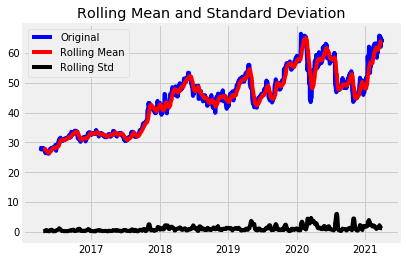

Results of dickey fuller test
Test Statistics                  -1.536224
p-value                           0.515522
No. of lags used                  9.000000
Number of observations used    1249.000000
critical value (1%)              -3.435596
critical value (5%)              -2.863857
critical value (10%)             -2.568004
dtype: float64


In [80]:
test_stationarity(df_INTC['fClose'])

## MSFT

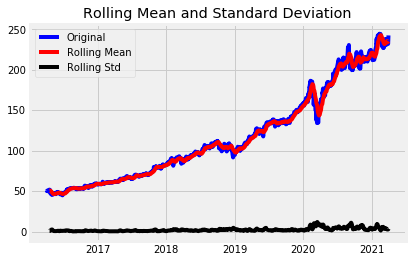

Results of dickey fuller test
Test Statistics                   1.273612
p-value                           0.996457
No. of lags used                 15.000000
Number of observations used    1242.000000
critical value (1%)              -3.435626
critical value (5%)              -2.863870
critical value (10%)             -2.568010
dtype: float64


In [81]:
test_stationarity(df_MSFT['fClose'])

## PYPL

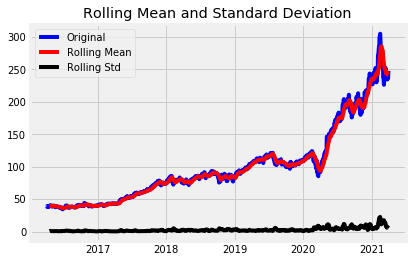

Results of dickey fuller test
Test Statistics                   0.991613
p-value                           0.994177
No. of lags used                 18.000000
Number of observations used    1240.000000
critical value (1%)              -3.435635
critical value (5%)              -2.863874
critical value (10%)             -2.568012
dtype: float64


In [82]:
test_stationarity(df_PYPL['fClose'])

## QCOM

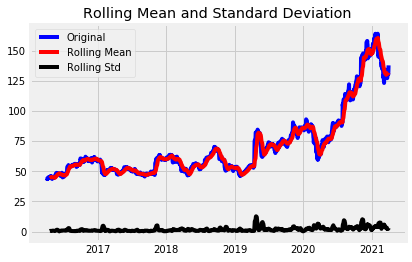

Results of dickey fuller test
Test Statistics                  -0.087184
p-value                           0.950700
No. of lags used                 16.000000
Number of observations used    1242.000000
critical value (1%)              -3.435626
critical value (5%)              -2.863870
critical value (10%)             -2.568010
dtype: float64


In [83]:
test_stationarity(df_QCOM['fClose'])

## SHOP

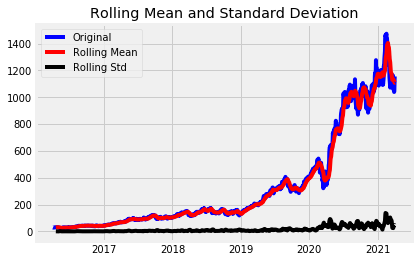

Results of dickey fuller test
Test Statistics                   1.242921
p-value                           0.996269
No. of lags used                 23.000000
Number of observations used    1235.000000
critical value (1%)              -3.435656
critical value (5%)              -2.863883
critical value (10%)             -2.568018
dtype: float64


In [84]:
test_stationarity(df_SHOP['fClose'])

# separate seasonality and trend from series

<Figure size 432x288 with 0 Axes>

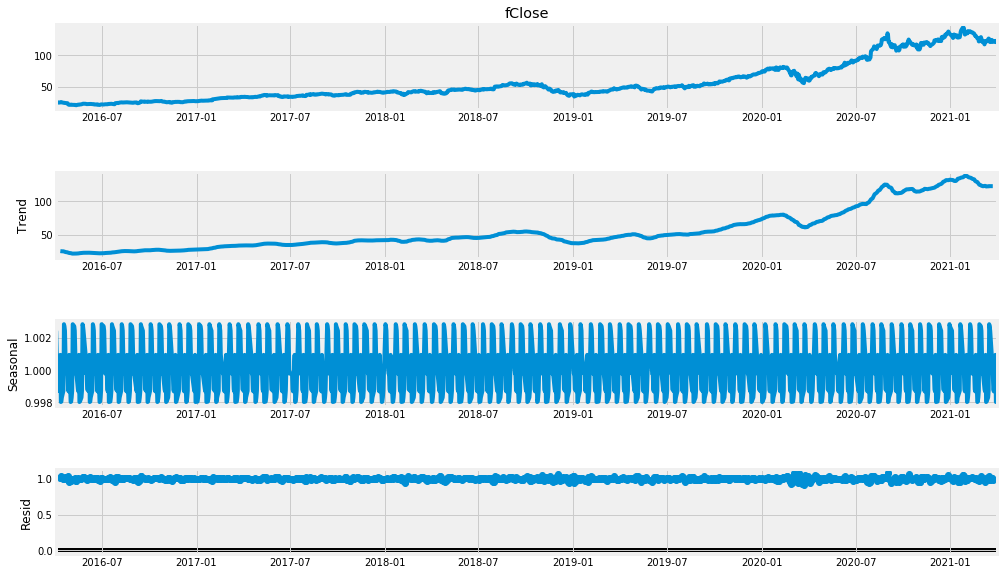

In [85]:
## AAPLE
result_AAPL = seasonal_decompose(df_AAPL['fClose'], model='multiplicative', freq = 13)
fig_AAPL = plt.figure()  
fig_AAPL = result_AAPL.plot()  
fig_AAPL.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

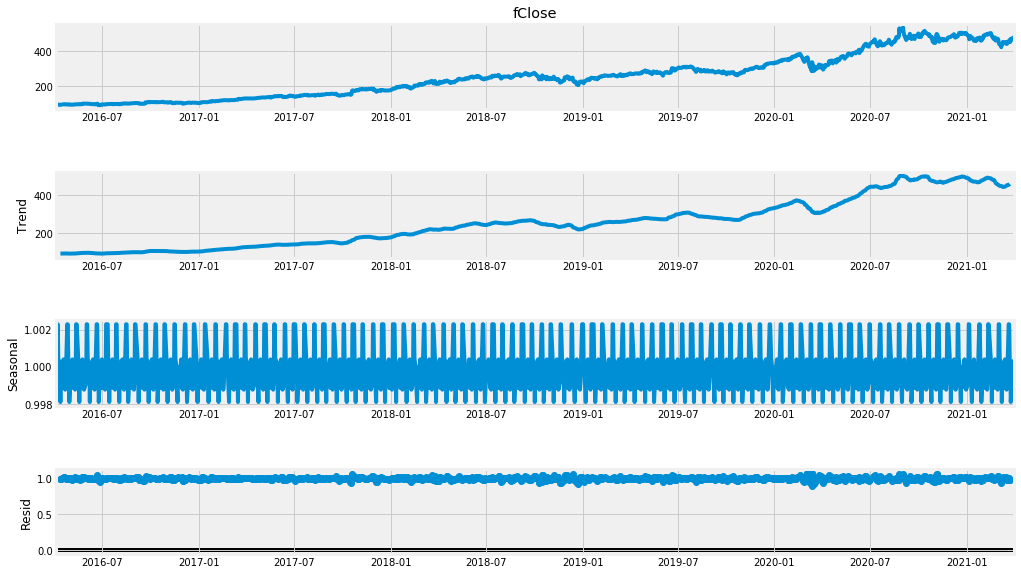

In [86]:
## ADBE
result_ADBE = seasonal_decompose(df_ADBE['fClose'], model='multiplicative', freq = 13)
fig_ADBE = plt.figure()  
fig_ADBE = result_ADBE.plot()  
fig_ADBE.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

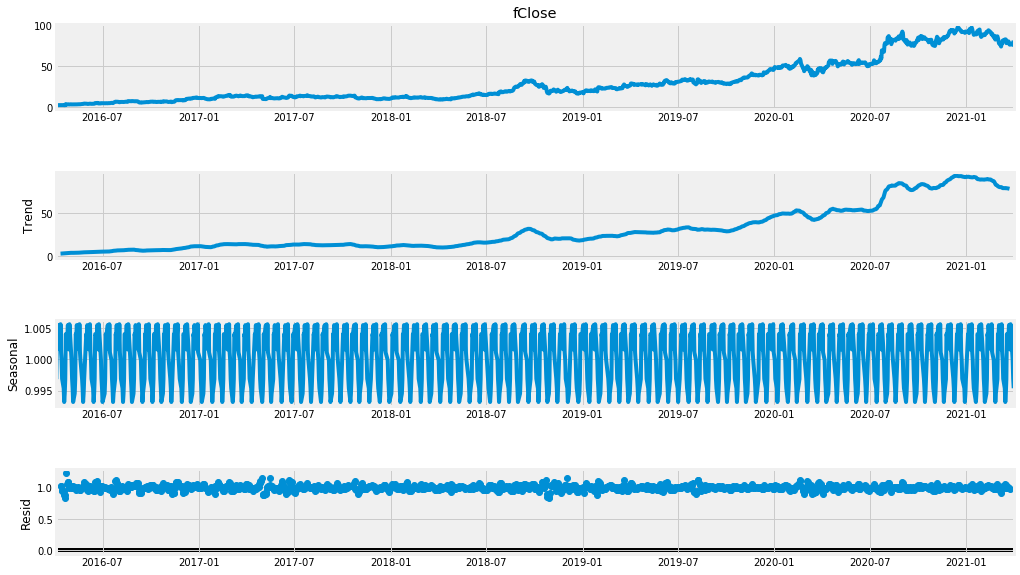

In [87]:
## AMD
result_AMD = seasonal_decompose(df_AMD['fClose'], model='multiplicative', freq = 13)
fig_AMD = plt.figure()  
fig_AMD = result_AMD.plot()  
fig_AMD.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

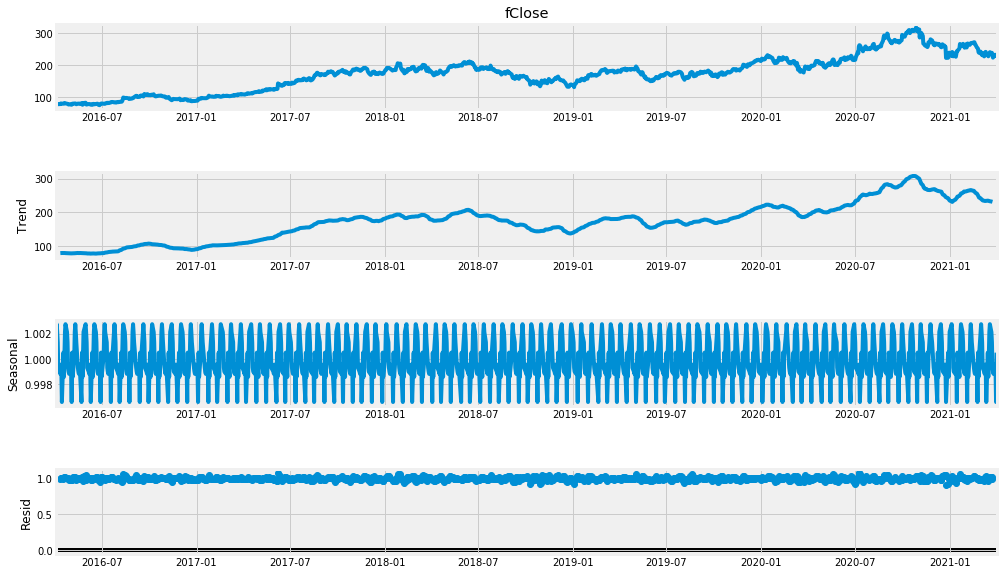

In [88]:
## BABA
result_BABA = seasonal_decompose(df_BABA['fClose'], model='multiplicative', freq = 13)
fig_BABA = plt.figure()  
fig_BABA = result_BABA.plot()  
fig_BABA.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

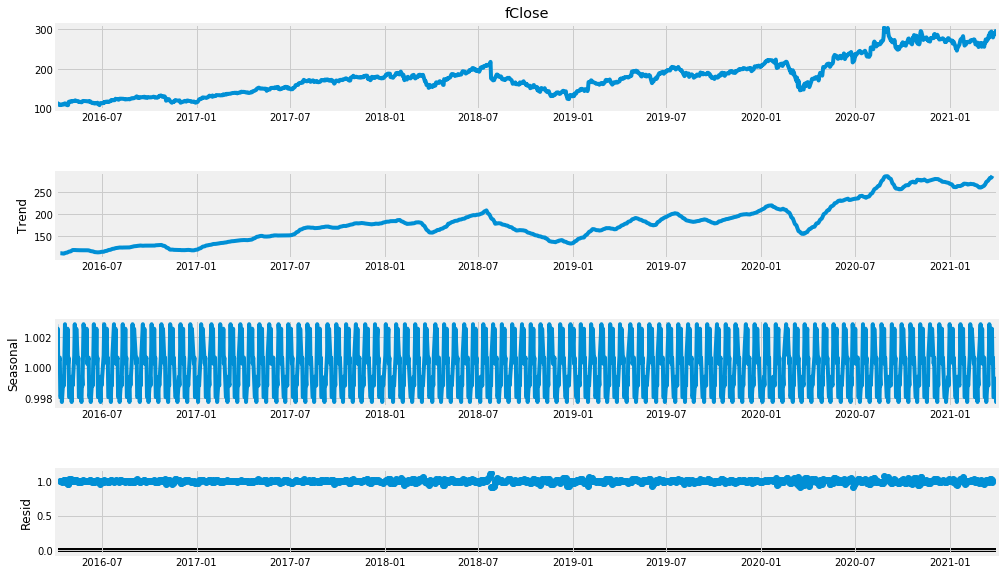

In [89]:
## FB
result_FB = seasonal_decompose(df_FB['fClose'], model='multiplicative', freq = 13)
fig_FB = plt.figure()  
fig_FB = result_FB.plot()  
fig_FB.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

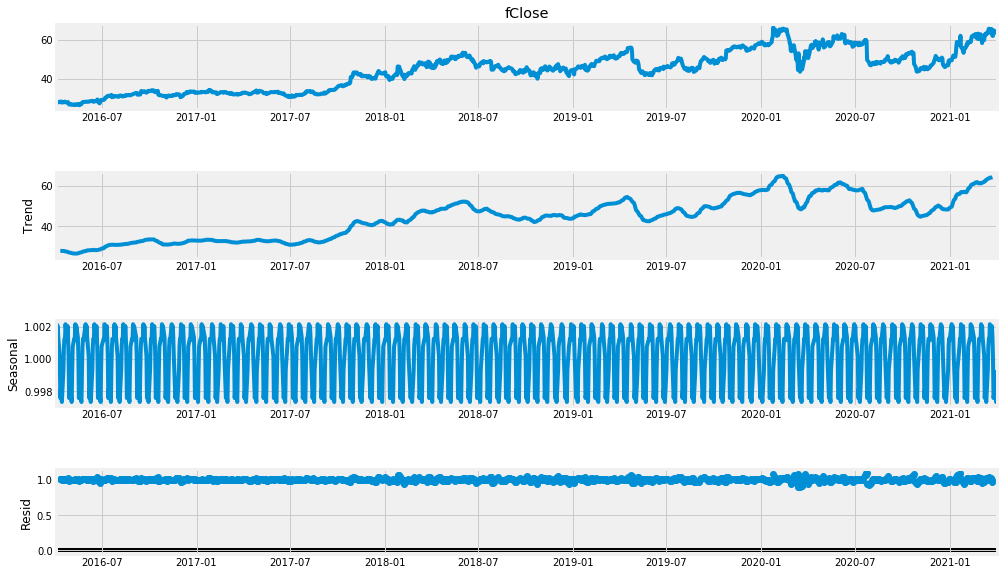

In [90]:
## INTC
result_INTC = seasonal_decompose(df_INTC['fClose'], model='multiplicative', freq = 13)
fig_INTC = plt.figure()  
fig_INTC = result_INTC.plot()  
fig_INTC.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

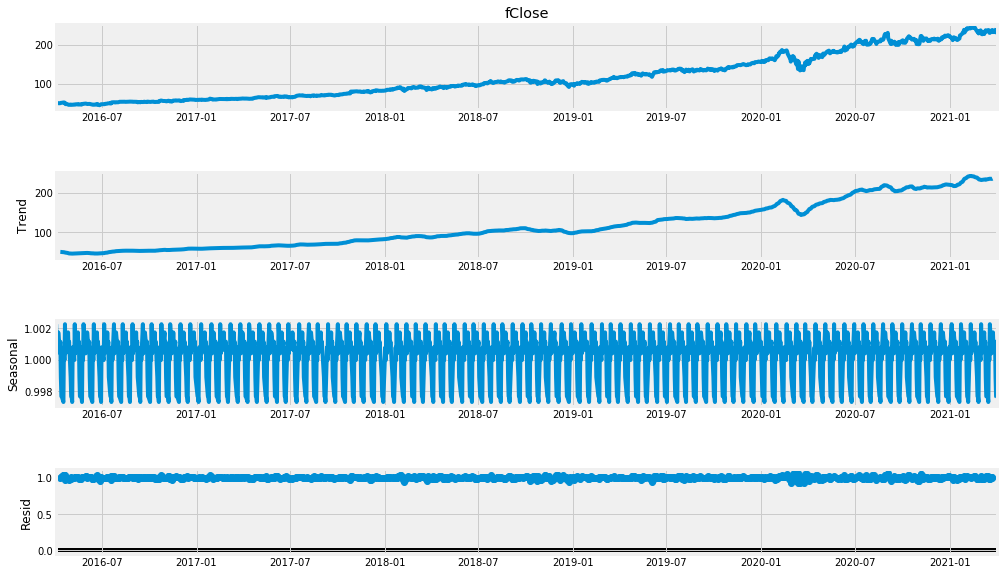

In [91]:
## MSFT
result_MSFT = seasonal_decompose(df_MSFT['fClose'], model='multiplicative', freq = 13)
fig_MSFT = plt.figure()  
fig_MSFT = result_MSFT.plot()  
fig_MSFT.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

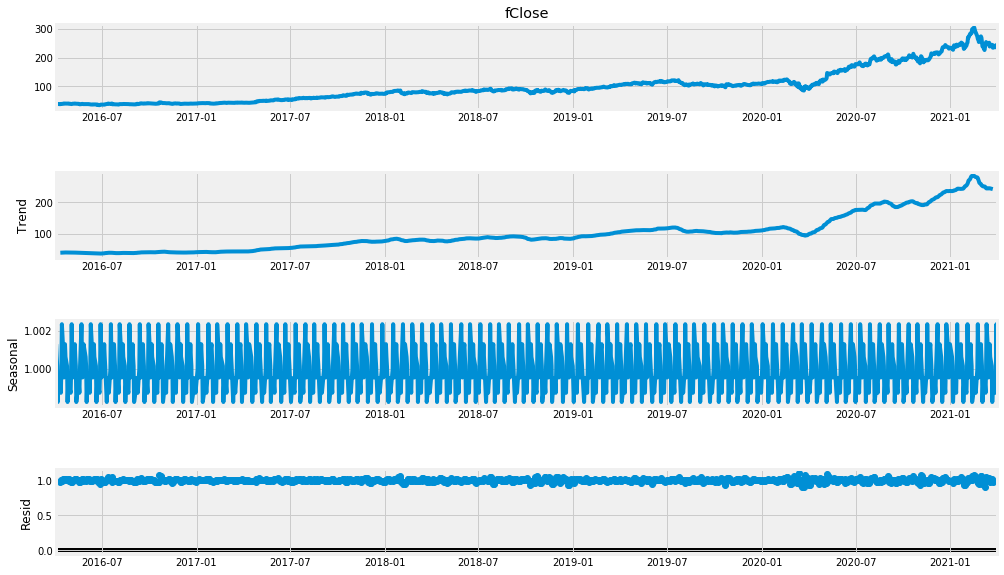

In [92]:
## PYPL
result_PYPL = seasonal_decompose(df_PYPL['fClose'], model='multiplicative', freq = 13)
fig_PYPL = plt.figure()  
fig_PYPL = result_PYPL.plot()  
fig_PYPL.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

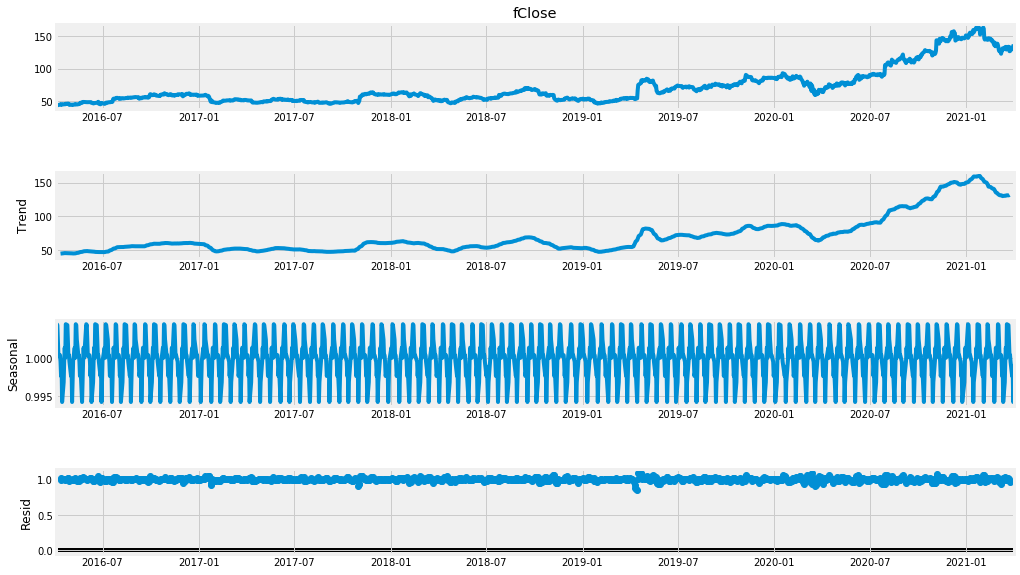

In [93]:
## QCOM
result_QCOM = seasonal_decompose(df_QCOM['fClose'], model='multiplicative', freq = 13)
fig_QCOM = plt.figure()  
fig_QCOM = result_QCOM.plot()  
fig_QCOM.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

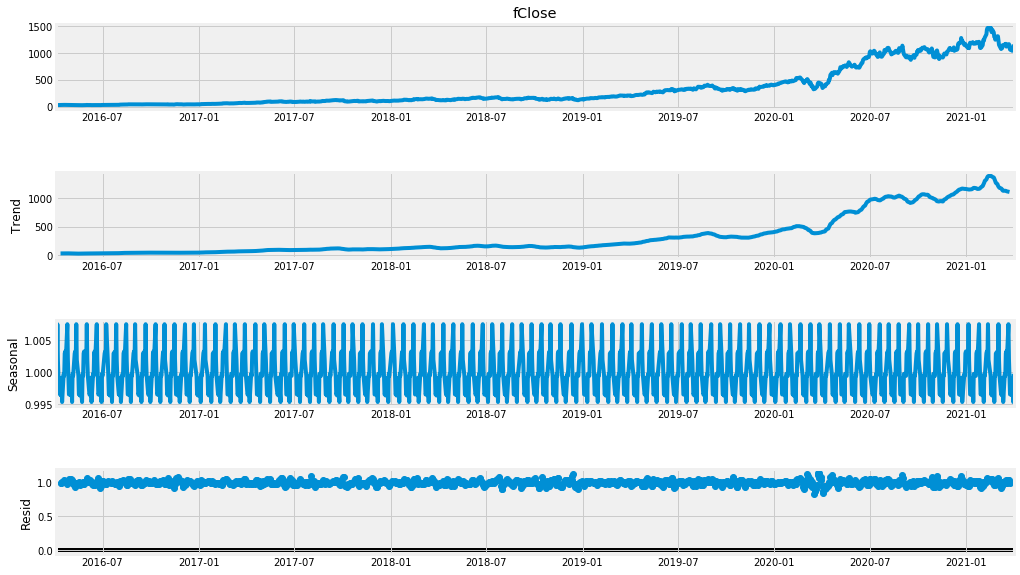

In [94]:
## SHOP
result_SHOP = seasonal_decompose(df_SHOP['fClose'], model='multiplicative', freq = 13)
fig_SHOP = plt.figure()  
fig_SHOP = result_SHOP.plot()  
fig_SHOP.set_size_inches(16, 9)

## ARIMA model - AAPL

In [95]:
train_data_AAPL, test_data_AAPL = df_AAPL[0:int(len(df_AAPL)*0.8)], df_AAPL[int(len(df_AAPL)*0.8):]
train_data_AAPL.head()

,fClose
label,
2016-04-04,25.8384
2016-04-05,25.5338
2016-04-06,25.8012
2016-04-07,25.2385
2016-04-08,25.2664


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2725.572, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2678.127, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2680.816, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2724.875, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2680.126, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2680.127, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2677.187, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2647.022, Time=0.68 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2681.195, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2644.168, Time=1.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2682.794, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2634.966, Time=0.81 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2680.314, Time=0.19 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=2627.033, Time=0.96 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept

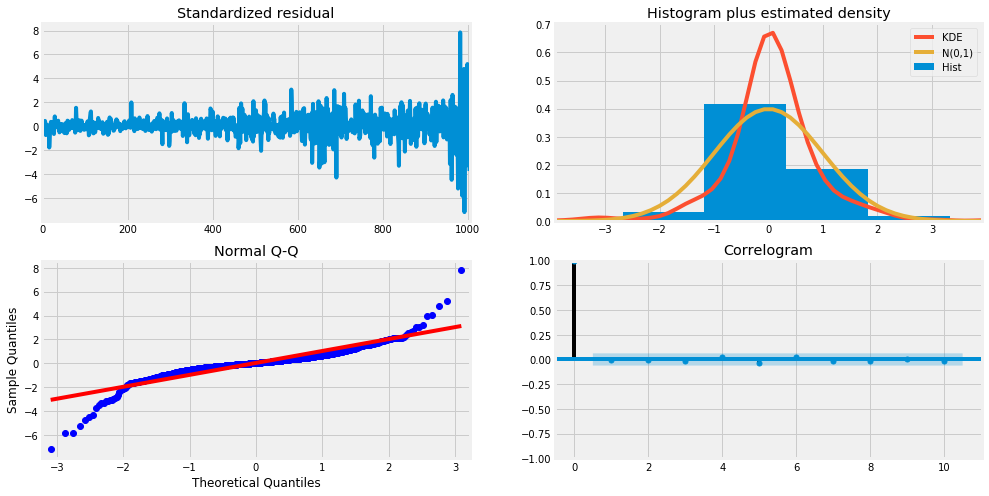

In [97]:
model_autoARIMA_AAPL = auto_arima(train_data_AAPL, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_AAPL.summary())
model_autoARIMA_AAPL.plot_diagnostics(figsize=(15,8))
plt.show()

In [100]:
train_data_AAPL, test_data_AAPL = df_AAPL[0:int(len(df_AAPL)*0.8)], df_AAPL[int(len(df_AAPL)*0.8):]
training_data_AAPL = train_data_AAPL['fClose'].values
testing_data_AAPL = test_data_AAPL['fClose'].values
history_AAPL = [x for x in training_data_AAPL]
model_predictions_AAPL = []
N_test_observations_AAPL = len(testing_data_AAPL)
for time_point in range(N_test_observations_AAPL):
    model = ARIMA(history_AAPL, order=(9,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_AAPL.append(yhat)
    true_test_value = testing_data_AAPL[time_point]
    history_AAPL.append(true_test_value)
    #print(yhat)
    print('predicted_AAPL=%f, expected_AAPL=%f' % (yhat, true_test_value))
MSE_error_AAPL = mean_squared_error(testing_data_AAPL, model_predictions_AAPL)
print('Testing Mean Squared Error of predicting AAPL is {}'.format(MSE_error_AAPL))
mae_AAPL = mean_absolute_error(testing_data_AAPL, model_predictions_AAPL)
print('MAE_AAPL: '+str(mae_AAPL))

predicted_AAPL=61.192146, expected_AAPL=60.761500
predicted_AAPL=59.282785, expected_AAPL=59.888300
predicted_AAPL=61.535191, expected_AAPL=65.112800
predicted_AAPL=63.450530, expected_AAPL=64.358600
predicted_AAPL=65.341725, expected_AAPL=66.005900
predicted_AAPL=65.440303, expected_AAPL=66.482200
predicted_AAPL=65.869441, expected_AAPL=67.787000
predicted_AAPL=68.732512, expected_AAPL=71.210500
predicted_AAPL=69.595707, expected_AAPL=70.560500
predicted_AAPL=72.030935, expected_AAPL=71.121200
predicted_AAPL=70.034043, expected_AAPL=70.156200
predicted_AAPL=71.620525, expected_AAPL=68.700000
predicted_AAPL=68.825724, expected_AAPL=66.576400
predicted_AAPL=67.019124, expected_AAPL=68.494100
predicted_AAPL=68.830252, expected_AAPL=68.228600
predicted_AAPL=67.649852, expected_AAPL=70.198400
predicted_AAPL=70.847180, expected_AAPL=70.248000
predicted_AAPL=69.776670, expected_AAPL=69.109300
predicted_AAPL=69.546793, expected_AAPL=71.379200
predicted_AAPL=70.750081, expected_AAPL=72.885000


predicted_AAPL=118.016998, expected_AAPL=118.463000
predicted_AAPL=118.496580, expected_AAPL=117.164900
predicted_AAPL=117.198251, expected_AAPL=113.680100
predicted_AAPL=114.455089, expected_AAPL=114.998200
predicted_AAPL=114.868694, expected_AAPL=115.856900
predicted_AAPL=115.873685, expected_AAPL=116.416000
predicted_AAPL=116.460984, expected_AAPL=118.872400
predicted_AAPL=118.573232, expected_AAPL=122.536900
predicted_AAPL=122.161676, expected_AAPL=122.896400
predicted_AAPL=122.879424, expected_AAPL=122.756600
predicted_AAPL=122.988930, expected_AAPL=122.067600
predicted_AAPL=121.796671, expected_AAPL=123.565400
predicted_AAPL=123.660506, expected_AAPL=124.194400
predicted_AAPL=124.371014, expected_AAPL=121.598300
predicted_AAPL=122.064775, expected_AAPL=123.056100
predicted_AAPL=122.900791, expected_AAPL=122.227400
predicted_AAPL=122.918866, expected_AAPL=121.598300
predicted_AAPL=121.701369, expected_AAPL=127.689200
predicted_AAPL=127.085534, expected_AAPL=127.619300
predicted_AA

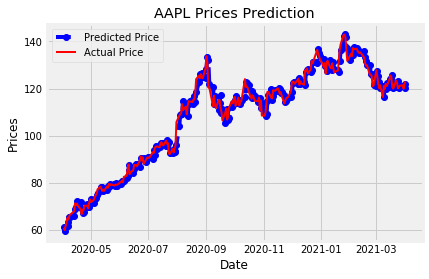

In [102]:
test_set_range_AAPL = df_AAPL[int(len(df_AAPL)*0.8):].index
plt.plot(test_set_range_AAPL, model_predictions_AAPL, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_AAPL, testing_data_AAPL, color='red', label='Actual Price', linewidth = 2)
plt.title('AAPL Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

## ARIMA model - ADBE

In [103]:
train_data_ADBE, test_data_ADBE = df_ADBE[0:int(len(df_ADBE)*0.8)], df_ADBE[int(len(df_ADBE)*0.8):]
train_data_ADBE.head()

,fClose
label,
2016-04-04,94.50
2016-04-05,94.17
2016-04-06,95.40
2016-04-07,93.78
2016-04-08,94.07


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6094.059, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5967.969, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5979.462, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6093.762, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5969.293, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5969.485, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5950.696, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5950.471, Time=0.58 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5966.229, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5965.347, Time=0.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5937.361, Time=1.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5965.430, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5965.768, Time=1.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5961.842, Time=1.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept

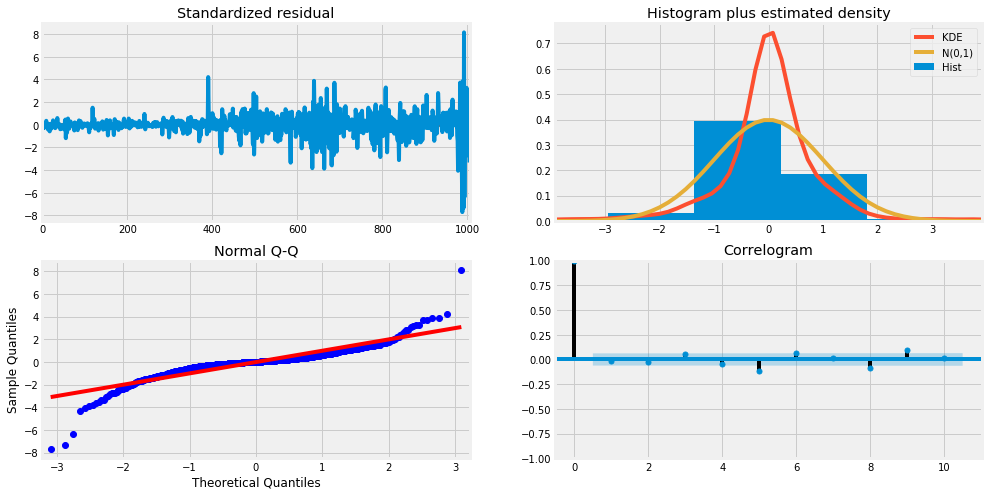

In [104]:
model_autoARIMA_ADBE = auto_arima(train_data_ADBE, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_ADBE.summary())
model_autoARIMA_ADBE.plot_diagnostics(figsize=(15,8))
plt.show()

In [105]:
train_data_ADBE, test_data_ADBE = df_ADBE[0:int(len(df_ADBE)*0.8)], df_ADBE[int(len(df_ADBE)*0.8):]
training_data_ADBE = train_data_ADBE['fClose'].values
testing_data_ADBE = test_data_ADBE['fClose'].values
history_ADBE = [x for x in training_data_ADBE]
model_predictions_ADBE = []
N_test_observations_ADBE = len(testing_data_ADBE)
for time_point in range(N_test_observations_ADBE):
    model = ARIMA(history_ADBE, order=(3,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_ADBE.append(yhat)
    true_test_value = testing_data_ADBE[time_point]
    history_ADBE.append(true_test_value)
    #print(yhat)
    print('predicted_ADBE=%f, expected_ADBE=%f' % (yhat, true_test_value))
MSE_error_ADBE = mean_squared_error(testing_data_ADBE, model_predictions_ADBE)
print('Testing Mean Squared Error of predicting ADBE is {}'.format(MSE_error_ADBE))
mae_ADBE = mean_absolute_error(testing_data_ADBE, model_predictions_ADBE)
print('MAE_ADBE: '+str(mae_ADBE))

predicted_ADBE=312.473980, expected_ADBE=303.960000
predicted_ADBE=296.205679, expected_ADBE=293.610000
predicted_ADBE=305.220103, expected_ADBE=319.130000
predicted_ADBE=303.004082, expected_ADBE=308.930000
predicted_ADBE=318.650423, expected_ADBE=317.180000
predicted_ADBE=312.185008, expected_ADBE=318.700000
predicted_ADBE=316.899345, expected_ADBE=320.650000
predicted_ADBE=325.012738, expected_ADBE=340.765000
predicted_ADBE=326.698701, expected_ADBE=332.550000
predicted_ADBE=344.299714, expected_ADBE=342.700000
predicted_ADBE=332.273322, expected_ADBE=344.110000
predicted_ADBE=348.462279, expected_ADBE=344.880000
predicted_ADBE=344.015041, expected_ADBE=328.990000
predicted_ADBE=333.652288, expected_ADBE=336.770000
predicted_ADBE=337.062191, expected_ADBE=335.370000
predicted_ADBE=331.803467, expected_ADBE=344.100000
predicted_ADBE=346.517964, expected_ADBE=348.500000
predicted_ADBE=341.823356, expected_ADBE=333.450000
predicted_ADBE=344.625981, expected_ADBE=349.170000
predicted_AD

predicted_ADBE=469.365952, expected_ADBE=460.950000
predicted_ADBE=467.154706, expected_ADBE=467.950000
predicted_ADBE=470.667812, expected_ADBE=459.470000
predicted_ADBE=465.473951, expected_ADBE=466.410000
predicted_ADBE=466.065791, expected_ADBE=462.920000
predicted_ADBE=462.951995, expected_ADBE=460.610000
predicted_ADBE=458.341744, expected_ADBE=462.700000
predicted_ADBE=458.691677, expected_ADBE=470.080000
predicted_ADBE=465.608985, expected_ADBE=477.030000
predicted_ADBE=474.631336, expected_ADBE=478.470000
predicted_ADBE=479.684842, expected_ADBE=479.150000
predicted_ADBE=482.102875, expected_ADBE=481.260000
predicted_ADBE=484.254450, expected_ADBE=484.280000
predicted_ADBE=486.211548, expected_ADBE=486.000000
predicted_ADBE=486.536389, expected_ADBE=492.250000
predicted_ADBE=489.602561, expected_ADBE=495.280000
predicted_ADBE=492.090529, expected_ADBE=483.740000
predicted_ADBE=484.046215, expected_ADBE=476.870000
predicted_ADBE=476.859376, expected_ADBE=475.910000
predicted_AD

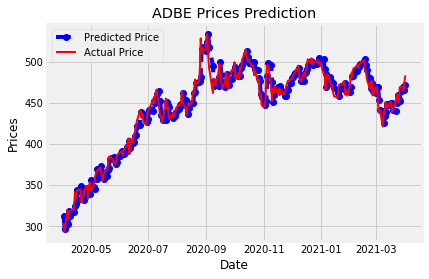

In [107]:
test_set_range_ADBE = df_ADBE[int(len(df_ADBE)*0.8):].index
plt.plot(test_set_range_ADBE, model_predictions_ADBE, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_ADBE, testing_data_ADBE, color='red', label='Actual Price', linewidth = 2)
plt.title('ADBE Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

## ARIMA model - BABA

In [112]:
train_data_BABA, test_data_BABA = df_BABA[0:int(len(df_BABA)*0.8)], df_BABA[int(len(df_BABA)*0.8):]
train_data_BABA.head()

,fClose
label,
2016-04-04,79.08
2016-04-05,77.32
2016-04-06,78.68
2016-04-07,77.61
2016-04-08,77.47


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5191.764, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5193.740, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5193.739, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5190.914, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5195.600, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.487 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1007
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2594.457
Date:                Tue, 08 Jun 2021   AIC                           5190.914
Time:                        12:48:28   BIC                           5195.828
Sample:                             0   HQIC                          5192.781
                               - 1007                                       

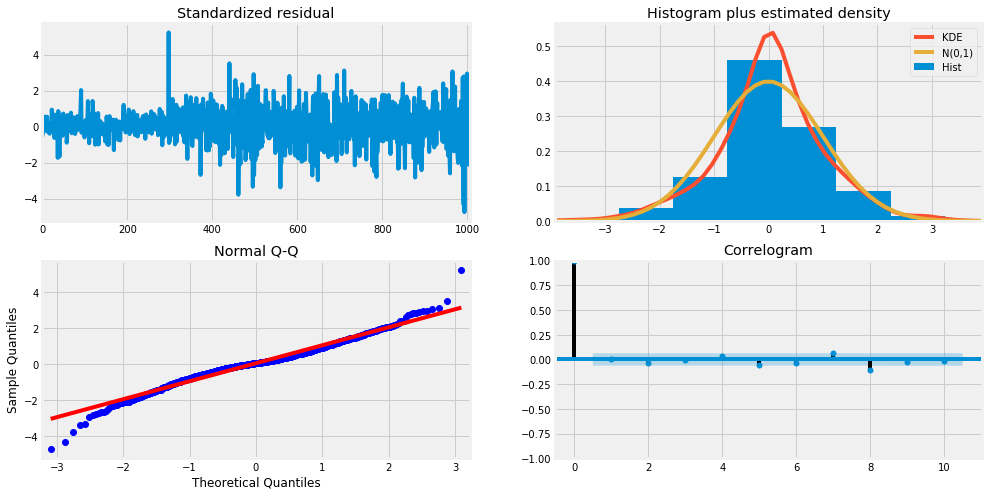

In [113]:
model_autoARIMA_BABA = auto_arima(train_data_BABA, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_BABA.summary())
model_autoARIMA_BABA.plot_diagnostics(figsize=(15,8))
plt.show()

In [120]:
train_data_BABA, test_data_BABA = df_BABA[0:int(len(df_BABA)*0.8)], df_BABA[int(len(df_BABA)*0.8):]
training_data_BABA = train_data_BABA['fClose'].values
testing_data_BABA = test_data_BABA['fClose'].values
history_BABA = [x for x in training_data_BABA]
model_predictions_BABA = []
N_test_observations_BABA = len(testing_data_BABA)
for time_point in range(N_test_observations_BABA):
    model = ARIMA(history_BABA, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_BABA.append(yhat)
    true_test_value = testing_data_BABA[time_point]
    history_BABA.append(true_test_value)
    #print(yhat)
    print('predicted_BABA=%f, expected_BABA=%f' % (yhat, true_test_value))
MSE_error_BABA = mean_squared_error(testing_data_BABA, model_predictions_BABA)
print('Testing Mean Squared Error of predicting BABA is {}'.format(MSE_error_BABA))
mae_BABA = mean_absolute_error(testing_data_BABA, model_predictions_BABA)
print('MAE_BABA: '+str(mae_BABA))

predicted_BABA=187.667833, expected_BABA=188.900000
predicted_BABA=189.009057, expected_BABA=187.110000
predicted_BABA=187.217173, expected_BABA=196.450000
predicted_BABA=196.566323, expected_BABA=198.000000
predicted_BABA=198.117743, expected_BABA=195.980000
predicted_BABA=196.095628, expected_BABA=196.370000
predicted_BABA=196.485899, expected_BABA=199.440000
predicted_BABA=199.558815, expected_BABA=204.780000
predicted_BABA=204.903965, expected_BABA=208.170000
predicted_BABA=208.297182, expected_BABA=212.660000
predicted_BABA=212.791476, expected_BABA=209.500000
predicted_BABA=209.628240, expected_BABA=212.130000
predicted_BABA=212.260697, expected_BABA=207.340000
predicted_BABA=207.465868, expected_BABA=209.960000
predicted_BABA=210.088314, expected_BABA=205.240000
predicted_BABA=205.363565, expected_BABA=204.360000
predicted_BABA=204.482583, expected_BABA=203.690000
predicted_BABA=203.811808, expected_BABA=201.150000
predicted_BABA=201.269209, expected_BABA=206.700000
predicted_BA

predicted_BABA=258.768380, expected_BABA=261.380000
predicted_BABA=261.530537, expected_BABA=265.920000
predicted_BABA=266.074158, expected_BABA=260.250000
predicted_BABA=260.399357, expected_BABA=260.760000
predicted_BABA=260.909654, expected_BABA=253.830000
predicted_BABA=253.973827, expected_BABA=264.690000
predicted_BABA=264.842640, expected_BABA=254.500000
predicted_BABA=254.644141, expected_BABA=263.430000
predicted_BABA=263.581355, expected_BABA=266.960000
predicted_BABA=267.114126, expected_BABA=265.670000
predicted_BABA=265.822943, expected_BABA=262.590000
predicted_BABA=262.740295, expected_BABA=266.490000
predicted_BABA=266.643363, expected_BABA=267.790000
predicted_BABA=267.944301, expected_BABA=268.930000
predicted_BABA=269.085106, expected_BABA=267.850000
predicted_BABA=268.004098, expected_BABA=270.700000
predicted_BABA=270.856297, expected_BABA=270.830000
predicted_BABA=270.986276, expected_BABA=264.510000
predicted_BABA=264.661002, expected_BABA=263.590000
predicted_BA

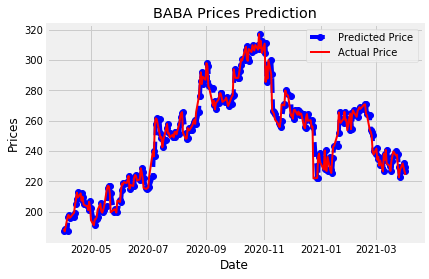

In [121]:
test_set_range_BABA = df_BABA[int(len(df_BABA)*0.8):].index
plt.plot(test_set_range_BABA, model_predictions_BABA, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_BABA, testing_data_BABA, color='red', label='Actual Price', linewidth = 2)
plt.title('BABA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

## ARIMA model - FB

In [117]:
train_data_FB, test_data_FB = df_FB[0:int(len(df_FB)*0.8)], df_FB[int(len(df_FB)*0.8):]
train_data_FB.head()

,fClose
label,
2016-04-04,112.55
2016-04-05,112.22
2016-04-06,113.71
2016-04-07,113.64
2016-04-08,110.63


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5253.516, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5242.671, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5243.149, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5251.719, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5244.557, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5244.591, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5246.400, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5240.935, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5242.815, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5242.851, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5241.417, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5244.651, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.522 seconds
                               SARIMAX Results                                
Dep. Vari

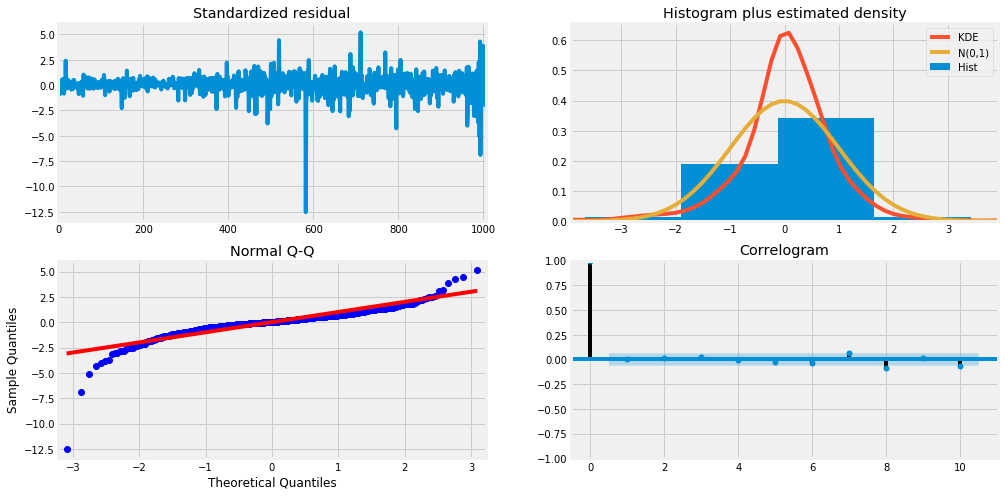

In [118]:
model_autoARIMA_FB = auto_arima(train_data_FB, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_FB.summary())
model_autoARIMA_FB.plot_diagnostics(figsize=(15,8))
plt.show()

In [122]:
train_data_FB, test_data_FB = df_FB[0:int(len(df_FB)*0.8)], df_FB[int(len(df_FB)*0.8):]
training_data_FB = train_data_FB['fClose'].values
testing_data_FB = test_data_FB['fClose'].values
history_FB = [x for x in training_data_FB]
model_predictions_FB = []
N_test_observations_FB = len(testing_data_FB)
for time_point in range(N_test_observations_FB):
    model = ARIMA(history_FB, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_FB.append(yhat)
    true_test_value = testing_data_FB[time_point]
    history_FB.append(true_test_value)
    #print(yhat)
    print('predicted_FB=%f, expected_FB=%f' % (yhat, true_test_value))
MSE_error_FB = mean_squared_error(testing_data_FB, model_predictions_FB)
print('Testing Mean Squared Error of predicting FB is {}'.format(MSE_error_FB))
mae_FB = mean_absolute_error(testing_data_FB, model_predictions_FB)
print('MAE_FB: '+str(mae_FB))

predicted_FB=160.465446, expected_FB=158.190000
predicted_FB=158.397558, expected_FB=154.180000
predicted_FB=154.670565, expected_FB=165.550000
predicted_FB=164.301855, expected_FB=168.830000
predicted_FB=168.530193, expected_FB=174.280000
predicted_FB=173.755868, expected_FB=175.190000
predicted_FB=175.160428, expected_FB=174.790000
predicted_FB=174.901285, expected_FB=178.170000
predicted_FB=177.876491, expected_FB=176.970000
predicted_FB=177.170389, expected_FB=176.250000
predicted_FB=176.397451, expected_FB=179.240000
predicted_FB=178.988516, expected_FB=178.240000
predicted_FB=178.420210, expected_FB=170.800000
predicted_FB=171.666124, expected_FB=182.280000
predicted_FB=181.035621, expected_FB=185.130000
predicted_FB=184.892967, expected_FB=190.070000
predicted_FB=189.612699, expected_FB=187.500000
predicted_FB=187.865460, expected_FB=182.910000
predicted_FB=183.488269, expected_FB=194.190000
predicted_FB=192.995457, expected_FB=204.710000
predicted_FB=203.732717, expected_FB=202

predicted_FB=273.983856, expected_FB=274.190000
predicted_FB=274.286083, expected_FB=275.550000
predicted_FB=275.589370, expected_FB=275.670000
predicted_FB=275.808978, expected_FB=274.480000
predicted_FB=274.723009, expected_FB=276.400000
predicted_FB=276.394567, expected_FB=272.790000
predicted_FB=273.227440, expected_FB=267.090000
predicted_FB=267.683594, expected_FB=268.110000
predicted_FB=268.169781, expected_FB=267.400000
predicted_FB=267.596891, expected_FB=277.000000
predicted_FB=276.379463, expected_FB=276.780000
predicted_FB=276.946161, expected_FB=271.870000
predicted_FB=272.406026, expected_FB=273.160000
predicted_FB=273.201803, expected_FB=268.940000
predicted_FB=269.420144, expected_FB=270.970000
predicted_FB=270.949128, expected_FB=263.310000
predicted_FB=264.070254, expected_FB=268.740000
predicted_FB=268.427712, expected_FB=267.570000
predicted_FB=267.807890, expected_FB=256.840000
predicted_FB=257.860154, expected_FB=251.090000
predicted_FB=251.668285, expected_FB=251

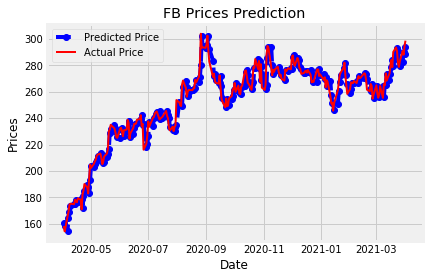

In [123]:
test_set_range_FB = df_FB[int(len(df_FB)*0.8):].index
plt.plot(test_set_range_FB, model_predictions_FB, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_FB, testing_data_FB, color='red', label='Actual Price', linewidth = 2)
plt.title('FB Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

## ARIMA model - MSFT

In [127]:
train_data_MSFT, test_data_MSFT = df_MSFT[0:int(len(df_MSFT)*0.8)], df_MSFT[int(len(df_MSFT)*0.8):]
train_data_MSFT.head()

,fClose
label,
2016-04-04,50.8277
2016-04-05,50.0300
2016-04-06,50.5435
2016-04-07,49.9383
2016-04-08,49.9016


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4310.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4161.531, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4181.442, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4310.509, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4162.537, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4162.950, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4105.824, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4148.538, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4139.857, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4149.720, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4146.569, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4137.290, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4168.797, Time=0.17 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 3.030 seconds
                      

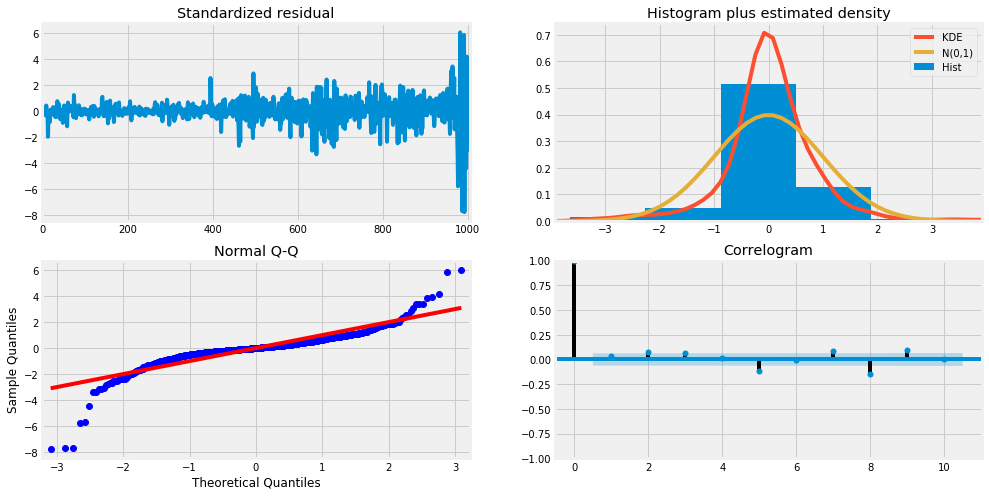

In [128]:
model_autoARIMA_MSFT = auto_arima(train_data_MSFT, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_MSFT.summary())
model_autoARIMA_MSFT.plot_diagnostics(figsize=(15,8))
plt.show()

In [129]:
train_data_MSFT, test_data_MSFT = df_MSFT[0:int(len(df_MSFT)*0.8)], df_MSFT[int(len(df_MSFT)*0.8):]
training_data_MSFT = train_data_MSFT['fClose'].values
testing_data_MSFT = test_data_MSFT['fClose'].values
history_MSFT = [x for x in training_data_MSFT]
model_predictions_MSFT = []
N_test_observations_MSFT = len(testing_data_MSFT)
for time_point in range(N_test_observations_MSFT):
    model = ARIMA(history_MSFT, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_MSFT.append(yhat)
    true_test_value = testing_data_MSFT[time_point]
    history_MSFT.append(true_test_value)
    #print(yhat)
    print('predicted_MSFT=%f, expected_MSFT=%f' % (yhat, true_test_value))
MSE_error_MSFT = mean_squared_error(testing_data_MSFT, model_predictions_MSFT)
print('Testing Mean Squared Error of predicting MSFT is {}'.format(MSE_error_MSFT))
mae_MSFT = mean_absolute_error(testing_data_MSFT, model_predictions_MSFT)
print('MAE_MSFT: '+str(mae_MSFT))

predicted_MSFT=153.664858, expected_MSFT=153.698100
predicted_MSFT=152.351124, expected_MSFT=152.282500
predicted_MSFT=152.987018, expected_MSFT=163.607400
predicted_MSFT=159.675028, expected_MSFT=161.845300
predicted_MSFT=161.489389, expected_MSFT=163.468800
predicted_MSFT=164.264238, expected_MSFT=163.478700
predicted_MSFT=162.344706, expected_MSFT=163.845000
predicted_MSFT=165.056409, expected_MSFT=171.952600
predicted_MSFT=168.011314, expected_MSFT=170.150900
predicted_MSFT=171.278577, expected_MSFT=175.259000
predicted_MSFT=173.459176, expected_MSFT=176.803300
predicted_MSFT=176.059900, expected_MSFT=173.298900
predicted_MSFT=174.931749, expected_MSFT=166.131800
predicted_MSFT=168.955638, expected_MSFT=171.774400
predicted_MSFT=170.466079, expected_MSFT=169.695500
predicted_MSFT=169.586388, expected_MSFT=172.794100
predicted_MSFT=172.975148, expected_MSFT=172.299100
predicted_MSFT=171.318710, expected_MSFT=168.101700
predicted_MSFT=171.070648, expected_MSFT=175.645100
predicted_MS

predicted_MSFT=215.290154, expected_MSFT=216.164900
predicted_MSFT=216.104646, expected_MSFT=213.408500
predicted_MSFT=214.421410, expected_MSFT=210.595000
predicted_MSFT=211.766579, expected_MSFT=211.931900
predicted_MSFT=211.727285, expected_MSFT=209.906500
predicted_MSFT=210.612876, expected_MSFT=209.627200
predicted_MSFT=210.068659, expected_MSFT=213.368600
predicted_MSFT=212.289107, expected_MSFT=213.378500
predicted_MSFT=213.495776, expected_MSFT=214.735400
predicted_MSFT=214.576842, expected_MSFT=213.578100
predicted_MSFT=213.978762, expected_MSFT=215.713200
predicted_MSFT=215.444466, expected_MSFT=214.875100
predicted_MSFT=215.031265, expected_MSFT=213.747700
predicted_MSFT=214.563184, expected_MSFT=213.867400
predicted_MSFT=213.806905, expected_MSFT=213.797600
predicted_MSFT=214.184838, expected_MSFT=215.513600
predicted_MSFT=215.028535, expected_MSFT=211.313300
predicted_MSFT=212.793608, expected_MSFT=210.036200
predicted_MSFT=210.772860, expected_MSFT=212.769900
predicted_MS

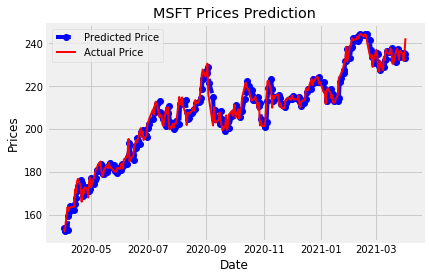

In [130]:
test_set_range_MSFT = df_MSFT[int(len(df_MSFT)*0.8):].index
plt.plot(test_set_range_MSFT, model_predictions_MSFT, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_MSFT, testing_data_MSFT, color='red', label='Actual Price', linewidth = 2)
plt.title('MSFT Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

## ARIMA model - PYPL

In [131]:
train_data_PYPL, test_data_PYPL = df_PYPL[0:int(len(df_PYPL)*0.8)], df_PYPL[int(len(df_PYPL)*0.8):]
train_data_PYPL.head()

,fClose
label,
2016-04-04,38.79
2016-04-05,38.55
2016-04-06,39.16
2016-04-07,38.28
2016-04-08,38.41


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3969.305, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3907.585, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3912.474, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3968.216, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3909.360, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3909.373, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3911.359, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3907.150, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3908.872, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3908.892, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3912.176, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3910.869, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.251 seconds
                               SARIMAX Results                                
Dep. Vari

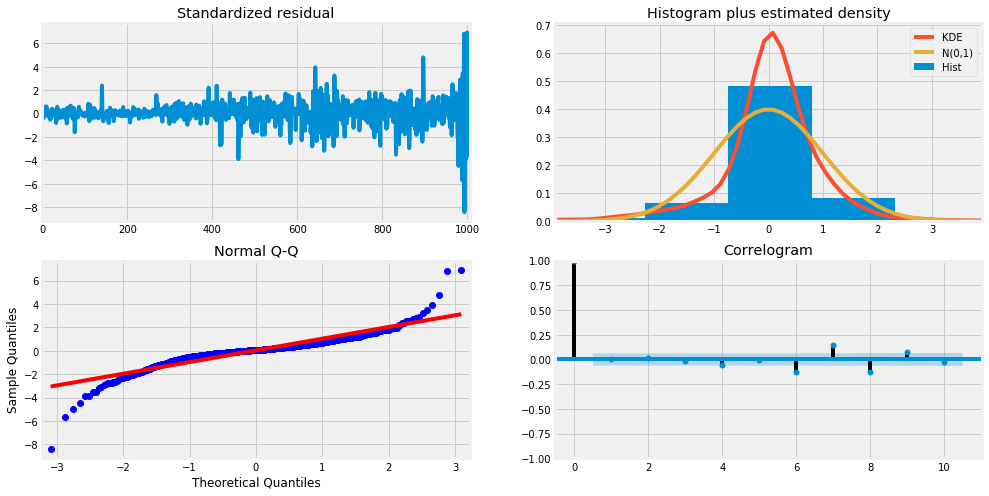

In [132]:
model_autoARIMA_PYPL = auto_arima(train_data_PYPL, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_PYPL.summary())
model_autoARIMA_PYPL.plot_diagnostics(figsize=(15,8))
plt.show()

In [133]:
train_data_PYPL, test_data_PYPL = df_PYPL[0:int(len(df_PYPL)*0.8)], df_PYPL[int(len(df_PYPL)*0.8):]
training_data_PYPL = train_data_PYPL['fClose'].values
testing_data_PYPL = test_data_PYPL['fClose'].values
history_PYPL = [x for x in training_data_PYPL]
model_predictions_PYPL = []
N_test_observations_PYPL = len(testing_data_PYPL)
for time_point in range(N_test_observations_PYPL):
    model = ARIMA(history_PYPL, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_PYPL.append(yhat)
    true_test_value = testing_data_PYPL[time_point]
    history_PYPL.append(true_test_value)
    #print(yhat)
    print('predicted_PYPL=%f, expected_PYPL=%f' % (yhat, true_test_value))
MSE_error_PYPL = mean_squared_error(testing_data_PYPL, model_predictions_PYPL)
print('Testing Mean Squared Error of predicting PYPL is {}'.format(MSE_error_PYPL))
mae_PYPL = mean_absolute_error(testing_data_PYPL, model_predictions_PYPL)
print('MAE_PYPL: '+str(mae_PYPL))

predicted_PYPL=92.529517, expected_PYPL=93.520000
predicted_PYPL=93.052795, expected_PYPL=92.390000
predicted_PYPL=92.739701, expected_PYPL=101.670000
predicted_PYPL=99.390847, expected_PYPL=100.280000
predicted_PYPL=100.705715, expected_PYPL=105.060000
predicted_PYPL=103.930869, expected_PYPL=105.840000
predicted_PYPL=105.727490, expected_PYPL=105.980000
predicted_PYPL=106.027948, expected_PYPL=109.785000
predicted_PYPL=108.919776, expected_PYPL=107.950000
predicted_PYPL=108.496977, expected_PYPL=108.310000
predicted_PYPL=108.305184, expected_PYPL=111.850000
predicted_PYPL=111.050972, expected_PYPL=112.170000
predicted_PYPL=112.180203, expected_PYPL=107.540000
predicted_PYPL=108.783153, expected_PYPL=115.190000
predicted_PYPL=113.298016, expected_PYPL=115.240000
predicted_PYPL=115.321304, expected_PYPL=120.180000
predicted_PYPL=119.019433, expected_PYPL=120.530000
predicted_PYPL=120.541661, expected_PYPL=116.140000
predicted_PYPL=117.346768, expected_PYPL=123.580000
predicted_PYPL=121

predicted_PYPL=188.831656, expected_PYPL=191.940000
predicted_PYPL=191.636399, expected_PYPL=192.300000
predicted_PYPL=192.400611, expected_PYPL=190.120000
predicted_PYPL=190.564343, expected_PYPL=190.900000
predicted_PYPL=190.941687, expected_PYPL=192.670000
predicted_PYPL=192.578582, expected_PYPL=200.820000
predicted_PYPL=199.883708, expected_PYPL=206.000000
predicted_PYPL=205.503417, expected_PYPL=214.460000
predicted_PYPL=213.610100, expected_PYPL=211.390000
predicted_PYPL=211.932880, expected_PYPL=214.120000
predicted_PYPL=213.949340, expected_PYPL=216.540000
predicted_PYPL=216.412156, expected_PYPL=212.560000
predicted_PYPL=213.220941, expected_PYPL=214.540000
predicted_PYPL=214.460343, expected_PYPL=217.770000
predicted_PYPL=217.539604, expected_PYPL=217.930000
predicted_PYPL=218.080984, expected_PYPL=216.940000
predicted_PYPL=217.232557, expected_PYPL=210.800000
predicted_PYPL=211.718782, expected_PYPL=215.340000
predicted_PYPL=214.935057, expected_PYPL=214.060000
predicted_PY

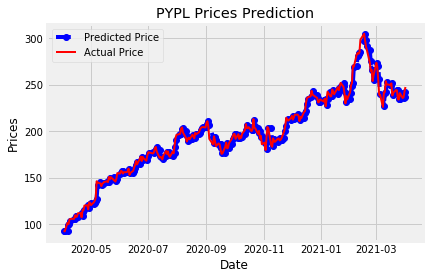

In [134]:
test_set_range_PYPL = df_PYPL[int(len(df_PYPL)*0.8):].index
plt.plot(test_set_range_PYPL, model_predictions_PYPL, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_PYPL, testing_data_PYPL, color='red', label='Actual Price', linewidth = 2)
plt.title('PYPL Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

## ARIMA model - QCOM

In [135]:
train_data_QCOM, test_data_QCOM = df_QCOM[0:int(len(df_QCOM)*0.8)], df_QCOM[int(len(df_QCOM)*0.8):]
train_data_QCOM.head()

,fClose
label,
2016-04-04,44.0685
2016-04-05,43.5639
2016-04-06,44.0424
2016-04-07,43.5291
2016-04-08,43.9902


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3546.691, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3538.535, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3540.707, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3544.900, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3523.726, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3523.792, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3522.402, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3533.023, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3524.386, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3524.367, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3523.185, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3526.336, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3520.561, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3531.273, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]          

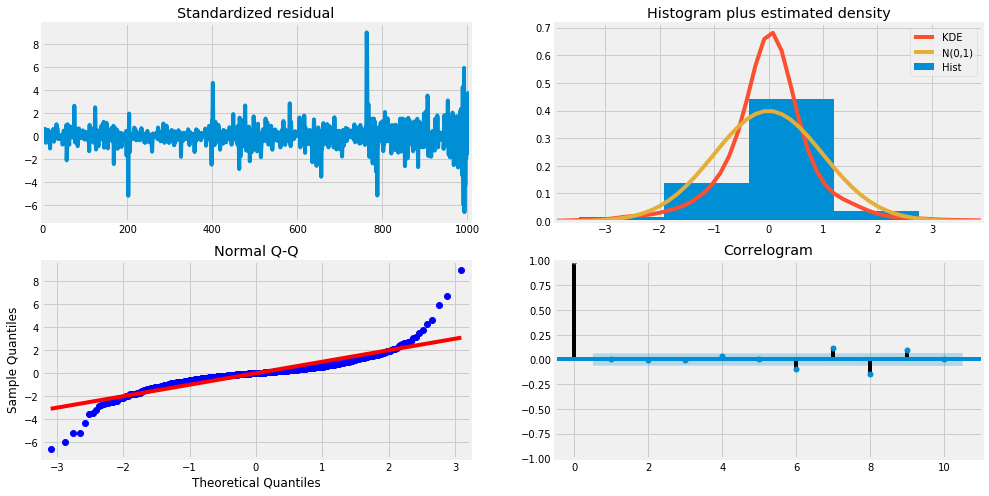

In [136]:
model_autoARIMA_QCOM = auto_arima(train_data_QCOM, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_QCOM.summary())
model_autoARIMA_QCOM.plot_diagnostics(figsize=(15,8))
plt.show()

In [137]:
train_data_QCOM, test_data_QCOM = df_QCOM[0:int(len(df_QCOM)*0.8)], df_QCOM[int(len(df_QCOM)*0.8):]
training_data_QCOM = train_data_QCOM['fClose'].values
testing_data_QCOM = test_data_QCOM['fClose'].values
history_QCOM = [x for x in training_data_QCOM]
model_predictions_QCOM = []
N_test_observations_QCOM = len(testing_data_QCOM)
for time_point in range(N_test_observations_QCOM):
    model = ARIMA(history_QCOM, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_QCOM.append(yhat)
    true_test_value = testing_data_QCOM[time_point]
    history_QCOM.append(true_test_value)
    #print(yhat)
    print('predicted_QCOM=%f, expected_QCOM=%f' % (yhat, true_test_value))
MSE_error_QCOM = mean_squared_error(testing_data_QCOM, model_predictions_QCOM)
print('Testing Mean Squared Error of predicting QCOM is {}'.format(MSE_error_QCOM))
mae_QCOM = mean_absolute_error(testing_data_QCOM, model_predictions_QCOM)
print('MAE_QCOM: '+str(mae_QCOM))

predicted_QCOM=64.594759, expected_QCOM=66.532400
predicted_QCOM=66.113680, expected_QCOM=63.803400
predicted_QCOM=64.258560, expected_QCOM=69.398300
predicted_QCOM=68.532407, expected_QCOM=71.139400
predicted_QCOM=71.603401, expected_QCOM=71.726300
predicted_QCOM=72.177419, expected_QCOM=70.014500
predicted_QCOM=70.475834, expected_QCOM=71.696900
predicted_QCOM=71.446435, expected_QCOM=75.854000
predicted_QCOM=75.644926, expected_QCOM=74.328100
predicted_QCOM=75.102841, expected_QCOM=75.169300
predicted_QCOM=75.197745, expected_QCOM=74.504200
predicted_QCOM=74.739944, expected_QCOM=72.684800
predicted_QCOM=72.871608, expected_QCOM=70.268900
predicted_QCOM=70.288731, expected_QCOM=73.046700
predicted_QCOM=72.391301, expected_QCOM=72.195800
predicted_QCOM=72.468954, expected_QCOM=74.377000
predicted_QCOM=74.148788, expected_QCOM=74.318300
predicted_QCOM=74.608926, expected_QCOM=73.643400
predicted_QCOM=73.840818, expected_QCOM=77.242900
predicted_QCOM=76.862228, expected_QCOM=76.949500


predicted_QCOM=146.055101, expected_QCOM=146.199300
predicted_QCOM=146.068761, expected_QCOM=144.712800
predicted_QCOM=144.980551, expected_QCOM=142.522700
predicted_QCOM=142.690479, expected_QCOM=144.613700
predicted_QCOM=144.206182, expected_QCOM=142.780400
predicted_QCOM=143.232920, expected_QCOM=142.532700
predicted_QCOM=142.484726, expected_QCOM=145.842500
predicted_QCOM=145.495625, expected_QCOM=149.895600
predicted_QCOM=149.878700, expected_QCOM=149.268600
predicted_QCOM=149.908297, expected_QCOM=149.199000
predicted_QCOM=149.326404, expected_QCOM=156.872400
predicted_QCOM=156.145368, expected_QCOM=157.270500
predicted_QCOM=158.098001, expected_QCOM=158.046800
predicted_QCOM=158.348738, expected_QCOM=155.280000
predicted_QCOM=155.812880, expected_QCOM=155.011300
predicted_QCOM=154.891691, expected_QCOM=143.595700
predicted_QCOM=144.782495, expected_QCOM=145.596100
predicted_QCOM=144.205909, expected_QCOM=147.656300
predicted_QCOM=147.531701, expected_QCOM=149.029800
predicted_QC

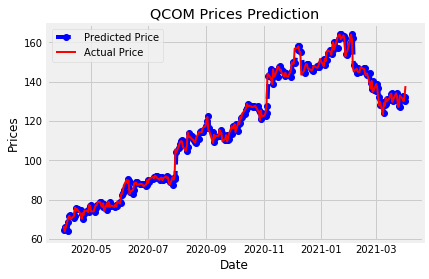

In [138]:
test_set_range_QCOM = df_QCOM[int(len(df_QCOM)*0.8):].index
plt.plot(test_set_range_QCOM, model_predictions_QCOM, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_QCOM, testing_data_QCOM, color='red', label='Actual Price', linewidth = 2)
plt.title('QCOM Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

## ARIMA model - SHOP

In [139]:
train_data_SHOP, test_data_SHOP = df_SHOP[0:int(len(df_SHOP)*0.8)], df_SHOP[int(len(df_SHOP)*0.8):]
train_data_SHOP.head()

,fClose
label,
2016-04-04,29.30
2016-04-05,28.75
2016-04-06,29.50
2016-04-07,29.21
2016-04-08,29.55


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6856.486, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6858.326, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6858.345, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6856.844, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6860.281, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.508 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1007
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3426.243
Date:                Tue, 08 Jun 2021   AIC                           6856.486
Time:                        13:07:37   BIC                           6866.314
Sample:                             0   HQIC                          6860.220
                               - 1007                                       

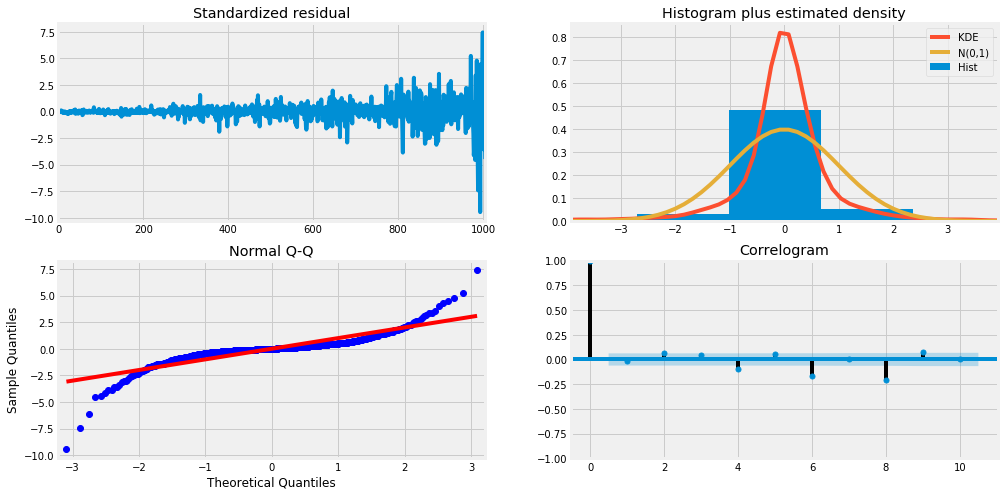

In [140]:
model_autoARIMA_SHOP = auto_arima(train_data_SHOP, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_SHOP.summary())
model_autoARIMA_SHOP.plot_diagnostics(figsize=(15,8))
plt.show()

In [141]:
train_data_SHOP, test_data_SHOP = df_SHOP[0:int(len(df_SHOP)*0.8)], df_SHOP[int(len(df_SHOP)*0.8):]
training_data_SHOP = train_data_SHOP['fClose'].values
testing_data_SHOP = test_data_SHOP['fClose'].values
history_SHOP = [x for x in training_data_SHOP]
model_predictions_SHOP = []
N_test_observations_SHOP = len(testing_data_SHOP)
for time_point in range(N_test_observations_SHOP):
    model = ARIMA(history_SHOP, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions_SHOP.append(yhat)
    true_test_value = testing_data_SHOP[time_point]
    history_SHOP.append(true_test_value)
    #print(yhat)
    print('predicted_SHOP=%f, expected_SHOP=%f' % (yhat, true_test_value))
MSE_error_SHOP = mean_squared_error(testing_data_SHOP, model_predictions_SHOP)
print('Testing Mean Squared Error of predicting SHOP is {}'.format(MSE_error_SHOP))
mae_SHOP = mean_absolute_error(testing_data_SHOP, model_predictions_SHOP)
print('MAE_SHOP: '+str(mae_SHOP))

predicted_SHOP=385.023250, expected_SHOP=346.300000
predicted_SHOP=346.614796, expected_SHOP=357.650000
predicted_SHOP=357.975744, expected_SHOP=392.650000
predicted_SHOP=393.010109, expected_SHOP=378.540000
predicted_SHOP=378.885782, expected_SHOP=414.510000
predicted_SHOP=414.891019, expected_SHOP=417.740000
predicted_SHOP=418.123834, expected_SHOP=447.450000
predicted_SHOP=447.862784, expected_SHOP=496.060000
predicted_SHOP=496.520316, expected_SHOP=497.170000
predicted_SHOP=497.630956, expected_SHOP=526.430000
predicted_SHOP=526.919301, expected_SHOP=590.390000
predicted_SHOP=590.941711, expected_SHOP=629.900000
predicted_SHOP=630.489980, expected_SHOP=585.000000
predicted_SHOP=585.545339, expected_SHOP=626.560000
predicted_SHOP=627.145549, expected_SHOP=620.490000
predicted_SHOP=621.069030, expected_SHOP=643.190000
predicted_SHOP=643.790675, expected_SHOP=628.580000
predicted_SHOP=629.165807, expected_SHOP=633.650000
predicted_SHOP=634.240186, expected_SHOP=639.990000
predicted_SH

predicted_SHOP=1020.364898, expected_SHOP=1034.390000
predicted_SHOP=1035.246854, expected_SHOP=1090.380000
predicted_SHOP=1091.283816, expected_SHOP=1069.060000
predicted_SHOP=1069.944902, expected_SHOP=1079.440000
predicted_SHOP=1080.332976, expected_SHOP=1062.680000
predicted_SHOP=1063.557978, expected_SHOP=1053.890000
predicted_SHOP=1054.759771, expected_SHOP=1084.400000
predicted_SHOP=1085.294911, expected_SHOP=1102.090000
predicted_SHOP=1102.999144, expected_SHOP=1038.190000
predicted_SHOP=1039.044268, expected_SHOP=1067.370000
predicted_SHOP=1068.248232, expected_SHOP=1057.870000
predicted_SHOP=1058.739459, expected_SHOP=1059.170000
predicted_SHOP=1060.039823, expected_SHOP=1074.100000
predicted_SHOP=1074.981688, expected_SHOP=1157.310000
predicted_SHOP=1158.261105, expected_SHOP=1180.000000
predicted_SHOP=1180.969419, expected_SHOP=1170.960000
predicted_SHOP=1171.920993, expected_SHOP=1197.260000
predicted_SHOP=1198.242304, expected_SHOP=1277.080000
predicted_SHOP=1278.128555, 

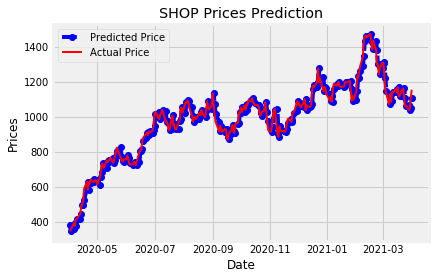

In [142]:
test_set_range_SHOP = df_SHOP[int(len(df_SHOP)*0.8):].index
plt.plot(test_set_range_SHOP, model_predictions_SHOP, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_SHOP, testing_data_SHOP, color='red', label='Actual Price', linewidth = 2)
plt.title('SHOP Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()